# Предсказание температуры стали

На основе данных о технологическом процессе получения стали необходимо спрогнозировать финальную температуру расплава, чтобы убедиться, что расплав пригоден для получения стали c требуемыми характеристиками.

##  План работы
### Шаг 1. Подготовка данных
- [1. Импорт библиотек, загрузка файлов, изучение общей информации](#section1)
- [2. Поиск аномалий](#section2)
- [3. Объединение данных, добавление фичей, обработка пропусков](#section3)
- [4. Обработка пропусков](#section4)

### [Шаг 2. Создание пайплайна](#section5)

### [Шаг 3. Обучение моделей](#section6)

### [Шаг 4. Проверка модели](#section7)

## Шаг 1. Подготовка данных

<a id='section1'></a>

#### 1. Импорт библиотек, загрузка файлов, изучение общей информации

Для начала импортируем необходимые библиотеки

In [1]:
import os
import gc
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.feature_selection import RFECV

Введем константы для дальнейших исследований

In [2]:
# Функции для аггрегации данных
AGG_FUNCS = ['count', 'mean', 'sum']

Далее прочитаем файлы с данными и изучим общую информацию.

In [3]:
# Путь к папке с данными
path = 'data/'

dfs = []
# Получим пути к файлам с данными
data_paths = sorted([os.path.join(path, filename) for filename in os.listdir(path) 
                          if filename.startswith('data_')])
# Прочитаем все файлы
for data_path in tqdm(data_paths, desc="Reading files"):
    df = pd.read_csv(data_path)
    dfs.append(df)
# Опишем функцию для изменения типа указанный столбцов на datetime
def to_dt(df, columns):
    for column in columns:
        df.iloc[:, column] = pd.to_datetime(df.iloc[:, column])
        
to_dt(dfs[0], [1, 2])    
    

dfs[0].info()
dfs[0].head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


Первый датафрейм содержит информацию о нагреве металла электродами. Столбец key содержит номер партии. Строк с одинаковыми номерами - несколько, значит в каждой партии нагрев может осуществляться несколько раз. Каждая итерация длится некоторое время, есть данные об активной и реактивной мощности.

In [4]:
dfs[1].info()
dfs[1].head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


Датафрейм bulk содержит данные о подаче сыпучих материалов. Для каждой партии в разных столбцах указан объем определенного материала. Из общей информации видно, что некоторые материалы засыпают чаще других, некоторые засыпают очень редко.

In [5]:
to_dt(dfs[2], [i for i in range(1,16)]) 
dfs[2].info()
dfs[2].head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaT,NaT,NaT,2019-05-03 13:59:24,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:53:27,NaT,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaT,NaT,NaT,2019-05-03 14:29:14,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 14:22:19,NaT,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaT,NaT,NaT,2019-05-03 15:04:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 14:55:46,NaT,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaT,NaT,NaT,2019-05-03 15:47:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 15:41:00,NaT,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 16:18:52,NaT,2019-05-03 16:18:52,2019-05-03 16:18:52


В данном датафрейме указано время засыпания каждого материала из предыдущего датафрейма. Эта информация позволяет определить, на какой итерации нагрева в каждой партии осуществлялась засыпка того или иного материала.

In [6]:
dfs[3].info()
dfs[3].head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


Данный датафрейм содержит информацию о количестве газа, используемого для продувки сплава в каждой партии. Так как по условиям задачи продувка осуществляется после каждого добавления сыпучих материалов, здесь явно не хватает данных о том, сколько газа использовалось на каждой итерации. Но так как данные всё равно будет в дальнейшем аггрегировать по ключу, это не так важно.

In [7]:
to_dt(dfs[4], [1]) 
dfs[4].info()
dfs[4].head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


В этом датафрейме представлены данные о температуре после некоторых итераций в каждой партии, но не после каждой итерации.

In [8]:
dfs[5].info()
dfs[5].head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Здесь указано количество проволочного материала, добавляемого в каждой партии. Проверим, сколько раз добавляют проволоку за партию.

In [9]:
max(dfs[5]['key'].value_counts())

1

То есть в каждой партии проволоку добабвляют не больше одного раза.

In [10]:
to_dt(dfs[6], [i for i in range(1,10)]) 
dfs[6].info()
dfs[6].head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaT,NaT,NaT,NaT,NaT,NaT,NaT
6,7,2019-05-03 14:28:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
7,8,2019-05-03 15:03:42,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaT,NaT,NaT,NaT,NaT,NaT,NaT
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Здесь указано время добавления проволоки. В отличие от сыпучих материалов, проволоку добавляют между итерациями нагрева.

<a id='section2'></a>

#### 2. Поиск аномалий

Изучим данные более подробно. Начнем с датафрейма с электродами.

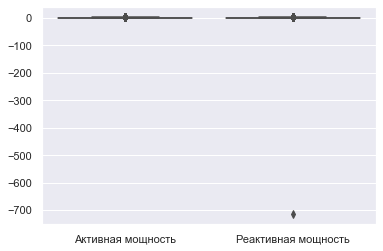

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [11]:
sns.set()
sns.boxplot(data=dfs[0].iloc[:,1:])
plt.show()
dfs[0].describe()

В столбце в реактивной мощностью есть очень большой отрицательный выброс. Это явно аномалия, которую нужно отбросить.

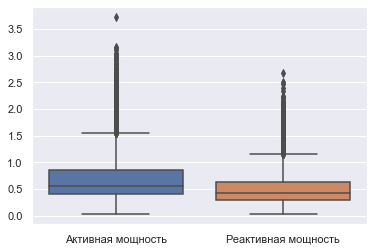

In [12]:
dfs[0] = dfs[0][(dfs[0]['Реактивная мощность'] >= 0)]
sns.boxplot(data=dfs[0].iloc[:,1:])
plt.show()

Сгруппируем данные по партиям и посмотрим на распределения.

In [13]:
dfs[0].groupby('key').agg(['min', 'mean', 'max', 'count']).describe()

Активная мощность                                         \
                    min         mean          max        count   
count       3214.000000  3214.000000  3214.000000  3214.000000   
mean           0.336554     0.671067     1.131704     4.628189   
std            0.148552     0.207490     0.469142     1.608866   
min            0.030002     0.186226     0.186226     1.000000   
25%            0.233681     0.519691     0.792262     4.000000   
50%            0.317511     0.646633     1.067059     4.000000   
75%            0.431849     0.797201     1.369758     6.000000   
max            1.129269     1.819169     3.731596    16.000000   

      Реактивная мощность                                         
                      min         mean          max        count  
count         3214.000000  3214.000000  3214.000000  3214.000000  
mean             0.249291     0.501532     0.861040     4.628189  
std              0.114230     0.153933     0.356742     1.608866  
min              0.020806     0.130062     0.150085     1.000000  
25%              0.168545     0.387213     0.604039     4.000000  
50%              0.233024     0.489478     0.805467     4.000000  
75%              0.321031     0.599788     1.049698     6.000000  
max              0.923811     1.141721     2.676388    16.000000

Из полученных данных видно, что нагрев электродами используется в среднем по 4 раза за партию.

Теперь изучим данные по сыпучим материалам.

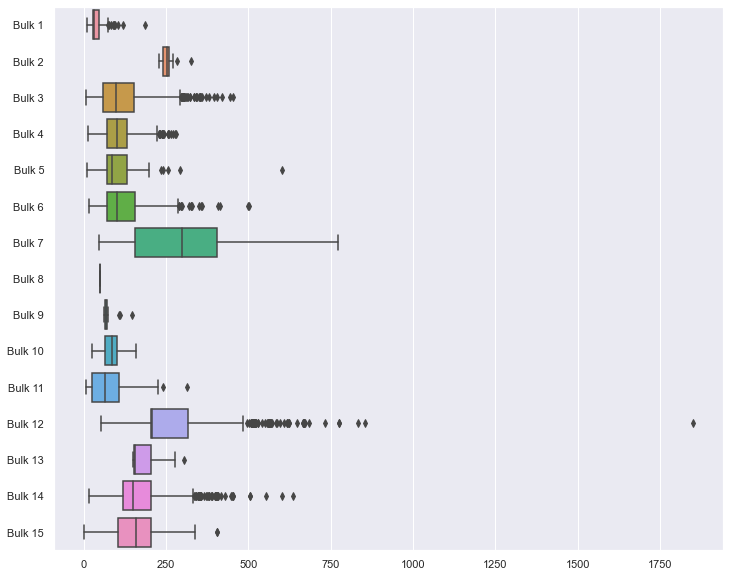

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [14]:
g = sns.boxplot(data=dfs[1].iloc[:,1:], orient='h')
g.figure.set_size_inches(12, 10) 
plt.show()
dfs[1].describe()

Есть сильно выбивающиеся значения в столбце Bulk 12. В остальных столбцах всё более-менее нормально.

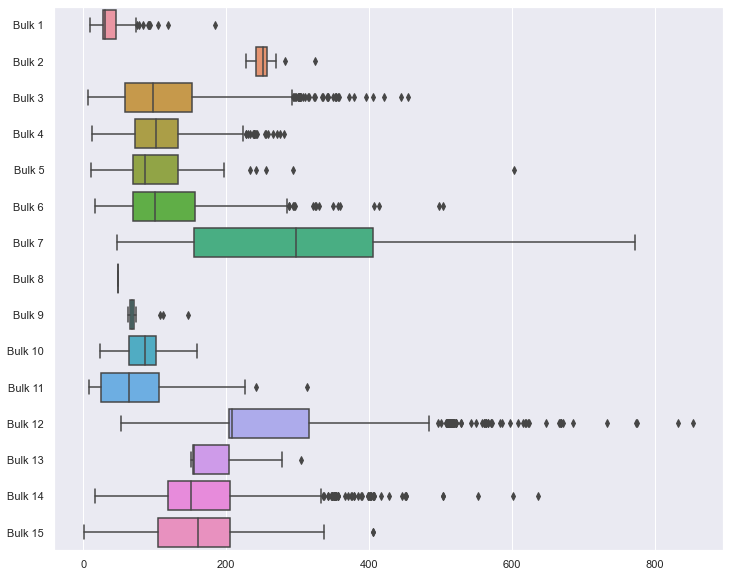

In [15]:
dfs[1] = dfs[1][dfs[1] < 1000]
g = sns.boxplot(data=dfs[1].iloc[:,1:], orient='h')
g.figure.set_size_inches(12, 10) 
plt.show()             

Посмотрим тоже самое по проволоке.

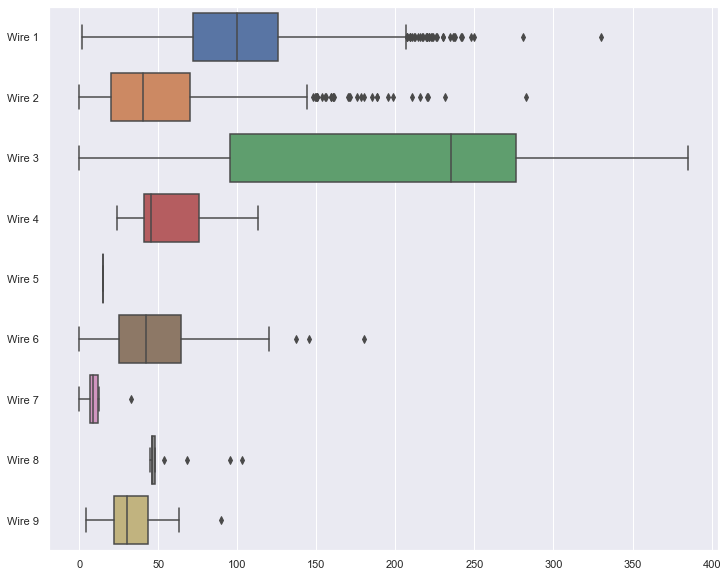

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [16]:
g = sns.boxplot(data=dfs[5].iloc[:,1:], orient='h')
g.figure.set_size_inches(12, 10) 
plt.show()
dfs[5].describe()

Проволока Wire 1 используется чаще остальных, в столбце с ней есть небольшие выбросы.

In [17]:
dfs[5] = dfs[5][(dfs[5]['Wire 1'] < 230)]

Теперь взглянем на данные по температуре.

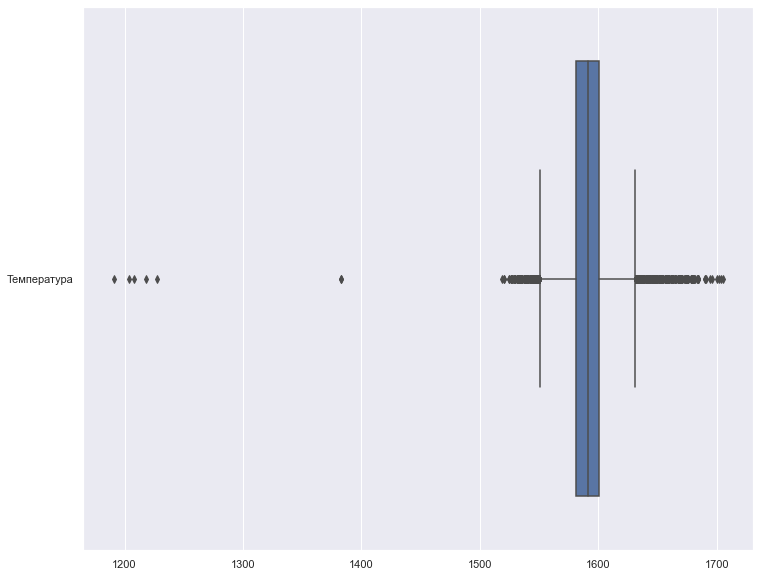

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [18]:
g = sns.boxplot(data=dfs[4].iloc[:,1:], orient='h')
g.figure.set_size_inches(12, 10)
plt.show()
dfs[4].describe()

Есть очень маленькие значения, явно аномалии. Ограничим диапазон температуры, что бы избавиться от выбросов.

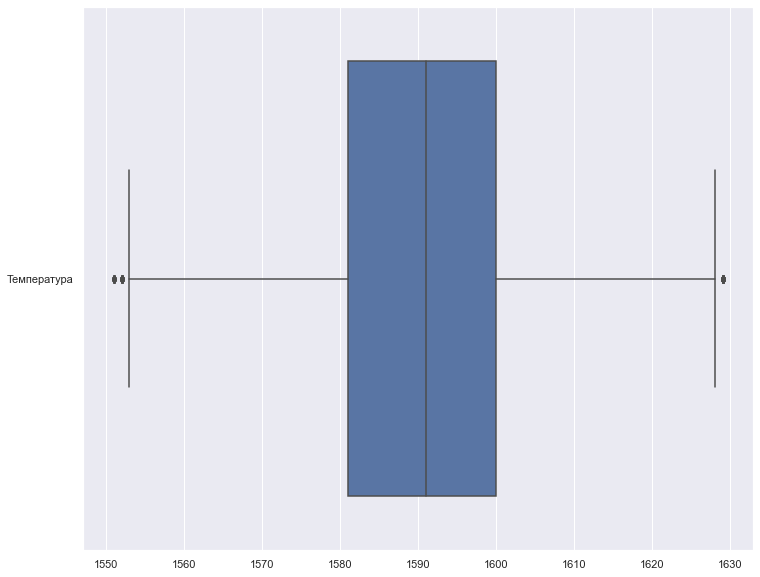

In [19]:
dfs[4] = dfs[4][(dfs[4]['Температура'] > 1550) &
                (dfs[4]['Температура'] < 1630)]
g = sns.boxplot(data=dfs[4].iloc[:,1:], orient='h')
g.figure.set_size_inches(12, 10)
plt.show()

Посмотрим на распределение использования газа для продувки.

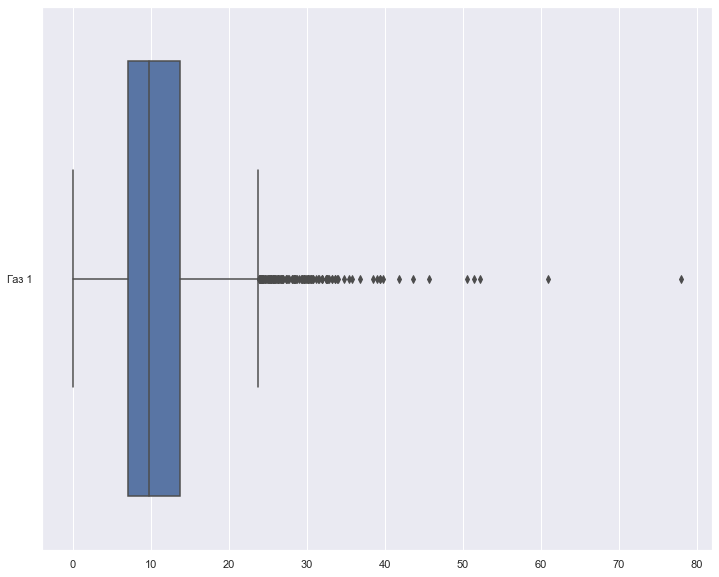

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [20]:
g = sns.boxplot(data=dfs[3].iloc[:,1:], orient='h')
g.figure.set_size_inches(12, 10)
plt.show()
dfs[3].describe()

Есть довольно большие значения, отбросим аномалии.

In [21]:
dfs[3] = dfs[3][dfs[3]['Газ 1'] < 50]

<a id='section3'></a>

#### 3. Объединение данных, добавление фичей

Теперь объединим все датафреймы в один. Но перед этим добавим несколько важных фичей в исходные данные.

In [22]:
df_power = dfs[0]
df_power.columns = ['key', 'heat_start', 'heat_end', 'active_power', 'reactive_power']
# Полная мощность
df_power['full_power'] = (df_power['active_power']**2 + df_power['reactive_power']**2)**0.5
# Время работы электрода - время нагрева
df_power['heat_time'] = (df_power['heat_end'] - df_power['heat_start']).dt.total_seconds()
# Отношение активной мощности к реактивной
df_power['active_reactive_ratio'] = df_power['active_power'] / df_power['reactive_power']
df_power

,key,heat_start,heat_end,active_power,reactive_power,full_power,heat_time,active_reactive_ratio
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228.0,1.420582
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185.0,1.548395
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172.0,1.492292
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365.0,1.561504
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148.0,1.671717
...,...,...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0.640648,157.0,1.505675
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0.855559,180.0,1.292139
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0.874560,184.0,1.542928
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0.264489,57.0,1.514004


Проверим фичи данного датафрейма на корреляцию.

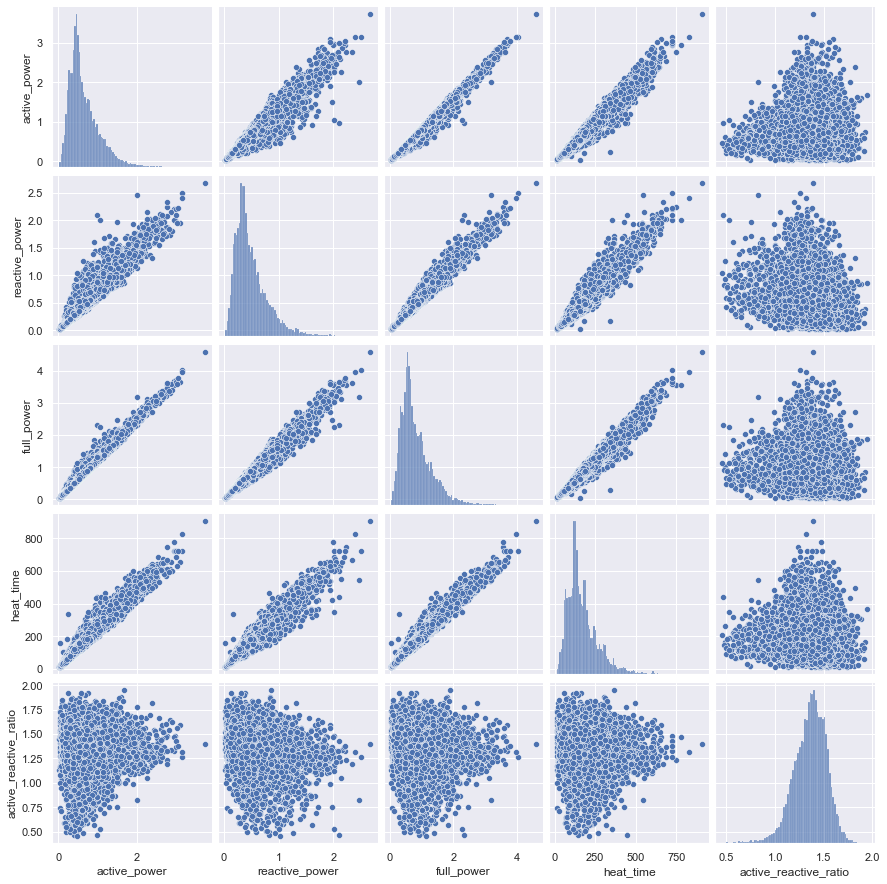

,active_power,reactive_power,full_power,heat_time,active_reactive_ratio
active_power,1.000000,0.963182,0.994279,0.974129,0.029174
reactive_power,0.963182,1.000000,0.986237,0.971269,-0.201989
full_power,0.994279,0.986237,1.000000,0.981205,-0.060334
heat_time,0.974129,0.971269,0.981205,1.000000,-0.082376
active_reactive_ratio,0.029174,-0.201989,-0.060334,-0.082376,1.000000


In [23]:
sns.pairplot(data=df_power.iloc[:,1:])
plt.show()
df_power.iloc[:,1:].corr()

Активная и реактивная мощность сильно коррелируют между собой. Новая фича полная мощность также коррелирует со всеми мощностями. Также полная мощность коррелирует с новой фичей время нагрева, что довольно логично. Отношение активной мощности к реактивной не коррелирует с другими признаками. Таким образом из всех мощностей лучше оставить только полную мощность, т.к. она содержит данные и об активной, и об реактивной мощностях. Время нагрева также убираем. Полная мощность и соотношение между активной и реактивной мощностью несут в себе намного больше информации, чем данные о времени нагрева и активной и реактивной мощности по отдельности. Лишние признаки удалим чуть позже, т.к. пока для других исследований требуются данные о времени нагрева.

Прежде, чем начать объединять данные, необходимо разобраться с температурой.

По условию задачи необходимо предсказывать конечное значение температуры. Также в условии сказано, что перед вводом легирующих добавок и первым нагревом сначала измеряется температура. Для выделения начальной и конечной температуры необходимо сначала сгруппировать данные по партиям, затем сравнить время последнего замера с временем окончания последнего нагрева.

In [24]:
df_temp = dfs[4].groupby('key').agg(['first','last'])
df_temp

Время замера                     Температура        
                   first                last       first    last
key                                                             
1    2019-05-03 11:16:18 2019-05-03 11:30:39      1571.0  1613.0
2    2019-05-03 11:37:27 2019-05-03 11:59:12      1581.0  1602.0
3    2019-05-03 12:13:17 2019-05-03 12:34:57      1596.0  1599.0
4    2019-05-03 12:52:57 2019-05-03 12:59:25      1601.0  1625.0
5    2019-05-03 13:23:19 2019-05-03 13:36:01      1576.0  1602.0
...                  ...                 ...         ...     ...
3237 2019-08-31 22:44:04 2019-08-31 22:44:04      1569.0  1569.0
3238 2019-08-31 23:30:31 2019-08-31 23:30:31      1584.0  1584.0
3239 2019-09-01 01:31:47 2019-09-01 01:31:47      1598.0  1598.0
3240 2019-09-01 02:39:01 2019-09-01 02:39:01      1617.0  1617.0
3241 2019-09-01 04:03:30 2019-09-01 04:03:30      1586.0  1586.0

[3079 rows x 4 columns]

Легко заметить, что в некоторых случаях время замера конечной температуры равняется времени замера начальной температуры. В таких случаях использовать значение температуры в качестве начальной нельзя, так как возникнет утечка таргета. Такие значения заменим на ноль, затем примем решение что делать с этими значениями.

In [25]:
# Заменяем значение начальной температуры на ноль
df_temp.loc[df_temp['Время замера']['first']==df_temp['Время замера']['last'],('Температура', 'first')] = 0
# Проверим успешность замены
df_temp[df_temp['Время замера']['first']==df_temp['Время замера']['last']]

Время замера                     Температура        
                   first                last       first    last
key                                                             
51   2019-05-05 05:48:48 2019-05-05 05:48:48         0.0  1619.0
52   2019-05-05 06:21:58 2019-05-05 06:21:58         0.0  1617.0
55   2019-05-05 08:27:17 2019-05-05 08:27:17         0.0  1615.0
56   2019-05-05 09:08:57 2019-05-05 09:08:57         0.0  1606.0
82   2019-05-06 06:59:25 2019-05-06 06:59:25         0.0  1621.0
...                  ...                 ...         ...     ...
3237 2019-08-31 22:44:04 2019-08-31 22:44:04         0.0  1569.0
3238 2019-08-31 23:30:31 2019-08-31 23:30:31         0.0  1584.0
3239 2019-09-01 01:31:47 2019-09-01 01:31:47         0.0  1598.0
3240 2019-09-01 02:39:01 2019-09-01 02:39:01         0.0  1617.0
3241 2019-09-01 04:03:30 2019-09-01 04:03:30         0.0  1586.0

[678 rows x 4 columns]

Теперь получим значения времени начала и окончания нагрева электродами.

In [26]:
df_power_groupby_order = df_power.groupby('key').agg(['first','last'])[['heat_start','heat_end']]
df_power_groupby_order

heat_start                                heat_end  \
                   first                last               first   
key                                                                
1    2019-05-03 11:02:14 2019-05-03 11:26:09 2019-05-03 11:06:02   
2    2019-05-03 11:34:14 2019-05-03 11:49:48 2019-05-03 11:36:31   
3    2019-05-03 12:06:54 2019-05-03 12:31:14 2019-05-03 12:11:34   
4    2019-05-03 12:39:37 2019-05-03 12:53:12 2019-05-03 12:43:04   
5    2019-05-03 13:11:13 2019-05-03 13:32:44 2019-05-03 13:15:24   
...                  ...                 ...                 ...   
3237 2019-08-31 22:41:18 2019-08-31 23:01:32 2019-08-31 22:43:17   
3238 2019-08-31 23:26:18 2019-08-31 23:38:38 2019-08-31 23:28:09   
3239 2019-09-01 01:26:53 2019-09-01 02:13:38 2019-09-01 01:29:20   
3240 2019-09-01 02:35:24 2019-09-01 03:31:47 2019-09-01 02:37:25   
3241 2019-09-01 03:58:58 2019-09-01 04:34:47 2019-09-01 04:01:35   

                          
                    last  
key                       
1    2019-05-03 11:28:37  
2    2019-05-03 11:53:18  
3    2019-05-03 12:32:19  
4    2019-05-03 12:57:50  
5    2019-05-03 13:33:55  
...                  ...  
3237 2019-08-31 23:03:48  
3238 2019-08-31 23:41:28  
3239 2019-09-01 02:15:43  
3240 2019-09-01 03:34:08  
3241 2019-09-01 04:36:08  

[3214 rows x 4 columns]

Объединим данные по температуре и по нагреву.

In [27]:
df_groupby_order = df_temp.join(df_power_groupby_order)
df_groupby_order

Время замера                     Температура          \
                   first                last       first    last   
key                                                                
1    2019-05-03 11:16:18 2019-05-03 11:30:39      1571.0  1613.0   
2    2019-05-03 11:37:27 2019-05-03 11:59:12      1581.0  1602.0   
3    2019-05-03 12:13:17 2019-05-03 12:34:57      1596.0  1599.0   
4    2019-05-03 12:52:57 2019-05-03 12:59:25      1601.0  1625.0   
5    2019-05-03 13:23:19 2019-05-03 13:36:01      1576.0  1602.0   
...                  ...                 ...         ...     ...   
3237 2019-08-31 22:44:04 2019-08-31 22:44:04         0.0  1569.0   
3238 2019-08-31 23:30:31 2019-08-31 23:30:31         0.0  1584.0   
3239 2019-09-01 01:31:47 2019-09-01 01:31:47         0.0  1598.0   
3240 2019-09-01 02:39:01 2019-09-01 02:39:01         0.0  1617.0   
3241 2019-09-01 04:03:30 2019-09-01 04:03:30         0.0  1586.0   

              heat_start                                heat_end  \
                   first                last               first   
key                                                                
1    2019-05-03 11:02:14 2019-05-03 11:26:09 2019-05-03 11:06:02   
2    2019-05-03 11:34:14 2019-05-03 11:49:48 2019-05-03 11:36:31   
3    2019-05-03 12:06:54 2019-05-03 12:31:14 2019-05-03 12:11:34   
4    2019-05-03 12:39:37 2019-05-03 12:53:12 2019-05-03 12:43:04   
5    2019-05-03 13:11:13 2019-05-03 13:32:44 2019-05-03 13:15:24   
...                  ...                 ...                 ...   
3237 2019-08-31 22:41:18 2019-08-31 23:01:32 2019-08-31 22:43:17   
3238 2019-08-31 23:26:18 2019-08-31 23:38:38 2019-08-31 23:28:09   
3239 2019-09-01 01:26:53 2019-09-01 02:13:38 2019-09-01 01:29:20   
3240 2019-09-01 02:35:24 2019-09-01 03:31:47 2019-09-01 02:37:25   
3241 2019-09-01 03:58:58 2019-09-01 04:34:47 2019-09-01 04:01:35   

                          
                    last  
key                       
1    2019-05-03 11:28:37  
2    2019-05-03 11:53:18  
3    2019-05-03 12:32:19  
4    2019-05-03 12:57:50  
5    2019-05-03 13:33:55  
...                  ...  
3237 2019-08-31 23:03:48  
3238 2019-08-31 23:41:28  
3239 2019-09-01 02:15:43  
3240 2019-09-01 03:34:08  
3241 2019-09-01 04:36:08  

[3079 rows x 8 columns]

Теперь можем определить, в каких случаях время замера температуры окажется позднее окончания нагрева.

In [28]:
np.mean(df_groupby_order['Время замера']['last']>df_groupby_order['heat_end']['last'])

0.7382266969795388

Из полученных результатов видно, что в 73.8% случаев последний замер сделан после окончания последнего нагрева. Во всех остальных случаях конечная температура неизвестна, а значит эти данные можно отбросить, т.к. таргет получается неизвесен.

Выделим отдельно признаки начальной и конечной температуры, добавим признак времени между замерами начальной и конечной температур.

In [29]:
# Выделим только те значения температуры, которые замерялись после окончания нагрева
df_temp = df_groupby_order[
    df_groupby_order['Время замера']['last']>df_groupby_order['heat_end']['last']]['Температура']['last']
# Преобразуем полученную серию в датафрейм
df_temp = pd.DataFrame(df_temp)
# Переименуем единственный столбец
df_temp.columns = ['temp']
# Получим время между замерами начальной и конечной температур
measure_time = (df_groupby_order['Время замера']['last'] - df_groupby_order['Время замера']['first']).dt.total_seconds()
# Отбросим значения, равные нулю
measure_time = measure_time[measure_time>0]
# Объединим все данные по температуре
df_temp = df_temp.join([df_groupby_order[df_groupby_order['Температура']['first']>0]['Температура']['first'], measure_time])
# Переименуем столбцы полученного датафрейма
df_temp.columns = ['temp', 'first_temp', 'measure_time']
df_temp

,temp,first_temp,measure_time
key,,,
1,1613.0,1571.0,861.0
2,1602.0,1581.0,1305.0
3,1599.0,1596.0,1300.0
4,1625.0,1601.0,388.0
5,1602.0,1576.0,762.0
...,...,...,...
2795,1617.0,NaN,NaN
2841,1616.0,NaN,NaN
2863,1582.0,NaN,NaN


Теперь аггрегируем данные по мощности. Перед этим выберем только те столбцы, между которыми нет корреляции, на основании исследования, проведенного ранее.

In [30]:
df_power_groupby = df_power[['key', 'full_power', 'active_reactive_ratio']].groupby('key').agg(AGG_FUNCS)
df_power_groupby

full_power                     active_reactive_ratio                     
          count      mean       sum                 count      mean        sum
key                                                                           
1             5  1.165279  5.826395                     5  1.538898   7.694490
2             4  0.912304  3.649216                     4  1.551834   6.207336
3             5  0.597907  2.989534                     5  1.583120   7.915599
4             4  0.953741  3.814962                     4  1.563487   6.253946
5             4  1.008939  4.035758                     4  1.480428   5.921711
...         ...       ...       ...                   ...       ...        ...
3237          5  0.968996  4.844982                     5  1.384203   6.921013
3238          3  0.898847  2.696542                     3  1.257794   3.773382
3239          8  0.701485  5.611883                     8  1.497918  11.983343
3240          5  0.778371  3.891856                     5  1.257343   6.286717
3241          5  0.599903  2.999516                     5  1.482661   7.413303

[3214 rows x 6 columns]

Для удобства избавимся от мультииндекса.

In [31]:
# Получим названия нулевого уровня
column_names = df_power_groupby.columns.levels[0].to_list()
new_column_names = []
# Получим новые названия колонок на основе аггрегурующей функции
for name in column_names:
    for agg_func in AGG_FUNCS:
        new_column_names.append(name + '_' + agg_func)
new_column_names
# Переименуем столбцы
df_power_groupby.columns = new_column_names
# Оставим только один столбец с количеством
df_power_groupby.drop([x for x in new_column_names if 'count' in x][1:], axis=1, inplace=True)
df_power_groupby

,full_power_count,full_power_mean,full_power_sum,active_reactive_ratio_mean,active_reactive_ratio_sum
key,,,,,
1,5,1.165279,5.826395,1.538898,7.694490
2,4,0.912304,3.649216,1.551834,6.207336
3,5,0.597907,2.989534,1.583120,7.915599
4,4,0.953741,3.814962,1.563487,6.253946
5,4,1.008939,4.035758,1.480428,5.921711
...,...,...,...,...,...
3237,5,0.968996,4.844982,1.384203,6.921013
3238,3,0.898847,2.696542,1.257794,3.773382
3239,8,0.701485,5.611883,1.497918,11.983343


Теперь добавим все остальные данные в новый датафрейм.

In [32]:
# Данные о сыпучих материалах
df_bulks = dfs[1].set_index('key')
# Данные о проволоке
df_wires = dfs[5].set_index('key')
# Данные о газе
df_gas = dfs[3].set_index('key')
df_gas.columns = ['gas']

# Объединим всё
df_full = df_temp.join([df_power_groupby, df_bulks, df_wires, df_gas])
df_full

,temp,first_temp,measure_time,full_power_count,full_power_mean,full_power_sum,active_reactive_ratio_mean,active_reactive_ratio_sum,Bulk 1,Bulk 2,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas
key,,,,,,,,,,,,,,,,,,,,,
1,1613.0,1571.0,861.0,5,1.165279,5.826395,1.538898,7.694490,NaN,NaN,...,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.749986
2,1602.0,1581.0,1305.0,4,0.912304,3.649216,1.551834,6.207336,NaN,NaN,...,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.555561
3,1599.0,1596.0,1300.0,5,0.597907,2.989534,1.583120,7.915599,NaN,NaN,...,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.554793
4,1625.0,1601.0,388.0,4,0.953741,3.814962,1.563487,6.253946,NaN,NaN,...,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.841219
5,1602.0,1576.0,762.0,4,1.008939,4.035758,1.480428,5.921711,NaN,NaN,...,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,1617.0,NaN,NaN,1,1.038381,1.038381,1.312537,1.312537,NaN,NaN,...,99.066238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.440840
2841,1616.0,NaN,NaN,1,0.774359,0.774359,1.424264,1.424264,NaN,NaN,...,90.111841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.751558
2863,1582.0,NaN,NaN,2,0.384244,0.768489,1.486680,2.973359,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.094691


Удалим лишние датафреймы, что бы очистить память.

In [33]:
del df_power_groupby, df_bulks, df_wires, df_gas, df_temp, df_groupby_order, df_power, dfs
gc.collect()

102759

<a id='section4'></a>

#### 4. Обработка пропусков

Теперь разберемся с пропусками. Сначала оценим количество пропусков в столбцах.

In [34]:
# Оценим количество пропусков в столбцах
print(df_full.isna().sum().sort_values(ascending=False) / len(df_full))

Wire 5                        1.000000
Bulk 8                        1.000000
Wire 7                        0.999120
Bulk 7                        0.999120
Wire 4                        0.997800
Bulk 2                        0.997800
Bulk 13                       0.997360
Bulk 9                        0.995601
Wire 8                        0.994281
Bulk 5                        0.992961
Wire 9                        0.989001
Bulk 11                       0.986802
Wire 3                        0.986362
Wire 6                        0.985042
Bulk 10                       0.978443
Bulk 1                        0.964804
Bulk 6                        0.929608
Bulk 4                        0.868896
Bulk 3                        0.849098
Bulk 15                       0.721513
Bulk 12                       0.694677
Wire 2                        0.656841
Bulk 14                       0.651562
Wire 1                        0.025517
measure_time                  0.003080
first_temp               

Пропуски в столбцах с данными о проволке и сыпучих материалах можно смело заполнять нулями, т.к. если нет данных, значит этим материалы не использовались. Пропуски в столбцах first_temp и measure_time получились операциями, сделанными ранее, они говорят о том, что первая температура совподала с последней. Т.к. таких пропусков очень мало - удалим такие строки. Пропусков в столбцах gas и Wire 1 очень мало, поэтому также удалим эти наблюдения.

In [35]:
df_full.dropna(subset=['gas', 'Wire 1', 'first_temp', 'measure_time'], inplace=True)
df_full.fillna(0, inplace=True)

## Вывод

Данные предобработаны. Пропусков нет, все аномальные значения отброшены. Можно переходить к настройке модели.

<a id='section5'></a>

## Шаг 2. Создание пайплайна

Сначала необходимо выделить признаки и целевой признак, разделить данные на тренировочные и тестовые, которые будут использованы для финальной проверки модели.

In [36]:
# Зададимся состоянием для воспроизводимости результатов
random_state = 2000

# Выделим признаки и целевой признак
X = df_full.drop('temp', axis=1)
y = df_full['temp']

# Разделим на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=random_state)

Для оценки качества модели будет использоваться метрика MAE. Гиперпараметры модели будут подбираться кросс-валидацией, поэтому необходимо разделить тренировочную выборку на фолды.

In [37]:
# Создадим метрику
mae = make_scorer(mean_absolute_error, greater_is_better=False)

# Разделим на фолды
kfs = list(KFold(n_splits=4, shuffle=True, random_state=random_state).split(X_train, y_train))

Не все признаки могут оказаться полезными, поэтому произведем оценку важности всех признаков.

In [38]:
def feature_selection(X, y, X_test, scoring, random_state=0):
    '''
    Функция определяет важность признаков, 
    возвращает самые важные тренировочные и тестовые признаки
    X - признаки
    y - целевой признак
    X_test - признаки тестовой выборки
    '''
    model = LGBMRegressor(random_state=random_state)
    model.fit(X, y)
    feat_import = pd.DataFrame({'Feature_Importance':model.feature_importances_, 'Feature':X.columns})    
    
    rfecv = RFECV(
        estimator=model, 
        step=1,
        cv=kfs,
        verbose=0,
        scoring=scoring,
        n_jobs=-1
    )
    rfecv.fit(X, y)
    X_columns_before = set(X.columns)
    X_columns_count_before = len(X_columns_before)
    X = X.loc[:, rfecv.support_]
    X_test = X_test.loc[:, rfecv.support_]
    X_columns_after = set(X.columns)
    X_columns_count_after = len(X_columns_after)
    
    # Построение графика важности признаков
    g = sns.catplot(x='Feature',
                    y='Feature_Importance',
                    data=feat_import.sort_values(by='Feature_Importance',ascending=False),
                    kind='bar',
                    height=10,
                    aspect=1.5,
                   )
    plt.setp(g.ax.get_xticklabels(), rotation=90)
    vert_line(X_columns_count_after-0.5, g, 'red', 'Граница важности признаков')
    plt.show()    
    
    print('Исходное количество признаков = {}, количество признаков после оптимизации = {}'.format(X_columns_count_before,
                                                                                                   X_columns_count_after))
    print('Список наименее важных признаков:', set.difference(X_columns_before, X_columns_after))
    return X, X_test

def vert_line(x, g, color, text):
    '''
    Функция построения вертикальной линии на графике
    '''
    plt.axvline(x, color=color, linestyle='dashed', alpha=.4)
    g.ax.text(x-.5,
            100,
            text,
            color=color,
            size=10,
            rotation=90,
            ha='center'
           )

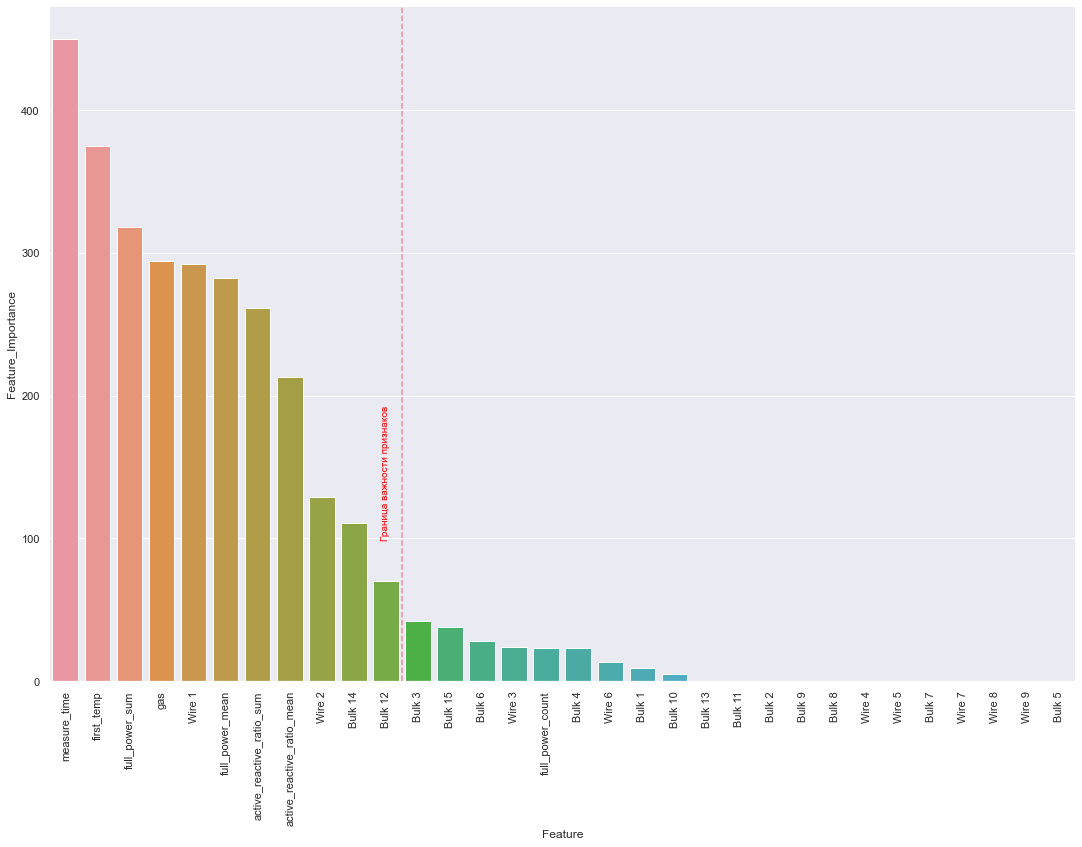

Исходное количество признаков = 32, количество признаков после оптимизации = 11
Список наименее важных признаков: {'full_power_count', 'Bulk 4', 'Bulk 2', 'Bulk 6', 'Bulk 7', 'Wire 3', 'Bulk 8', 'Wire 6', 'Bulk 3', 'Bulk 11', 'Bulk 9', 'Wire 5', 'Bulk 10', 'Wire 4', 'Wire 9', 'Bulk 15', 'Wire 8', 'Bulk 1', 'Bulk 13', 'Bulk 5', 'Wire 7'}


In [39]:
X_train_2, X_test_2 = feature_selection(X_train, y_train, X_test, mae, random_state=321)

Видно, какие признаки являются наиболее важными, а какие не так важны. Для ускорения вычислений можно отбросить наименее важные признаки. Но дальнейшие эксперименты показали, что качество модели без наименее важных признаков получается немного ниже, поэтому принято решение обучать модели на всех данных.

Теперь сформируем пайплайн. Для дополнительной предобработки данных в некоторых случаях попробуем применить StandardScaler или MinMaxScaler. Вторым этапом будет обучение модели. В качестве моделей попробуем линейные модели с регуляризацией и без нее, подбирая коэффициент регуляризации. Также попробуем модель случайного леса. Попробуем кэтбуст "из коробки" с различным количеством итераций (валидационную выборку для ранней остановки обучения кэтбуста в кросс-валидации использовать очень сложно, поэтому будем подбирать количество итераций). Последней моделью используем лайтгбм с различными параметрами.

In [40]:
# Сформируем пайплайн
estimators = [('transformer', StandardScaler()),
              ('model', LinearRegression())
             ]

pipe = Pipeline(estimators)

# Зададим варианты изменения гиперпараметров
param_grid = [{'transformer': ['passthrough',
                               StandardScaler(),
                               MinMaxScaler()
                              ],
               'model': [LinearRegression()]               
              },
              {'transformer': ['passthrough',
                               StandardScaler(),
                               MinMaxScaler()
                              ],
               'model': [Ridge()],
               'model__alpha': [0.1, 1, 10, 100]               
              },
              {'transformer': ['passthrough',
                               StandardScaler(),
                               MinMaxScaler()
                              ],
               'model': [Lasso()],
               'model__alpha': [0.1, 1, 10, 100]
              },
              {'transformer': ['passthrough',
                               StandardScaler(),
                               MinMaxScaler()
                              ],
               'model': [RandomForestRegressor(random_state=random_state)],
               'model__max_depth': range(1, 31, 15),
               'model__min_samples_leaf': range(1, 32, 15),
               'model__min_samples_split': range(2, 33, 15),
               'model__n_estimators': [100] 
              },
              {'transformer': ['passthrough'],
               'model': [CatBoostRegressor(iterations=1000,
                                          loss_function='MAE',
                                          eval_metric='MAE',
                                          early_stopping_rounds=100,
                                          random_state=random_state,
                                           verbose=400)],
               'model__iterations': [100, 500, 1000, 2000]
              },
              {'transformer': ['passthrough'],
               'model': [LGBMRegressor(n_estimators=100,
                                       objective='mean_absolute_error',
                                       #early_stopping_rounds=100,
                                       random_state=random_state)],
               'model__boosting_type': ['goss'],
               'model__learning_rate': [0.001, 0.1],
               'model__num_leaves': range(10, 71, 30),
               'model__max_depth': [10, 100],
               'model__reg_alpha': [0.0, 0.1],
               'model__reg_lambda': [0.0, 0.1],
               'model__min_split_gain': [0.0, 1],
               'model__subsample': [0.0, 0.5, 1],
               'model__n_estimators': [100]
              }
             ]

# Опишем GridSearchCV
grid = GridSearchCV(pipe,
                    param_grid,                          
                    scoring=mae,
                    n_jobs=-1,
                    cv=kfs,
                    verbose=1
                   )

## Вывод

Пайплайн сформирован, можно приступать к обучению моделей.

<a id='section6'></a>

## Шаг 3. Обучение моделей

Выполним обучение GridSearchCV на сформированном пайплайне.

In [41]:
%%time
grid.fit(X_train, y_train)

Fitting 4 folds for each of 373 candidates, totalling 1492 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 1492 out of 1492 | elapsed:  1.3min finished


0:	learn: 7.9570908	total: 147ms	remaining: 4m 54s
400:	learn: 4.1840876	total: 1.2s	remaining: 4.8s
800:	learn: 3.4698622	total: 2.27s	remaining: 3.4s
1200:	learn: 3.1272434	total: 3.16s	remaining: 2.1s
1600:	learn: 2.9152199	total: 4.07s	remaining: 1.01s
1999:	learn: 2.7646263	total: 4.98s	remaining: 0us
Wall time: 1min 25s


GridSearchCV(cv=[(array([   1,    2,    3, ..., 1760, 1761, 1763]),
                  array([   0,    7,   12,   18,   19,   20,   23,   24,   25,   27,   31,
         36,   43,   45,   59,   68,   77,   78,   84,   87,   90,   94,
         95,  100,  106,  109,  111,  113,  114,  120,  122,  127,  133,
        136,  137,  143,  149,  150,  151,  153,  155,  165,  167,  175,
        180,  181,  182,  185,  189,  201,  210,  212,  217,  221,  224,
        225,  229,  233,  234,  235,  242,  244,  245,  248,  251,  267,
        269,  289,  294,  296,  302,  303,  307,  310,  313,  316,  321,
        322,  324,...
                          'model__learning_rate': [0.001, 0.1],
                          'model__max_depth': [10, 100],
                          'model__min_split_gain': [0.0, 1],
                          'model__n_estimators': [100],
                          'model__num_leaves': range(10, 71, 30),
                          'model__reg_alpha': [0.0, 0.1],
                   

Получим значение метрики MAE лучшей модели на тренировочной выборке.

In [42]:
grid_best_score = grid.best_score_*(-1)
grid_best_score

5.762255941267474

Запишем параметры лучшей модели в пайплайн и обучим ее на всех тренировочных данных.

In [43]:
pipe = grid.best_estimator_
pipe

Pipeline(steps=[('transformer', 'passthrough'),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x00000220621C36D0>)])

In [44]:
pipe.fit(X_train, y_train)

0:	learn: 7.9570908	total: 3.06ms	remaining: 6.11s
400:	learn: 4.1840876	total: 927ms	remaining: 3.7s
800:	learn: 3.4698622	total: 1.98s	remaining: 2.97s
1200:	learn: 3.1272434	total: 2.86s	remaining: 1.9s
1600:	learn: 2.9152199	total: 3.79s	remaining: 945ms
1999:	learn: 2.7646263	total: 4.74s	remaining: 0us


Pipeline(steps=[('transformer', 'passthrough'),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x00000220621C36D0>)])

## Вывод

Получена лучшая модель, выдающая отличный результат на тренировочной выборке.

<a id='section7'></a>

## Шаг 4. Проверка модели

Проверим обученную модель на тестовых данных

In [45]:
print('MAE модели на тестовой выборке =', mean_absolute_error(y_test, pipe.predict(X_test)))

MAE модели на тестовой выборке = 4.729685632077275


Значение метрики - 4.73. Отличный результат.

Проверим модель на адекватность. Для этого сравним значение метрики нашей модели с метрикой константной модели.

In [46]:
y_const = pd.Series(np.mean(y_train), index=y_test.index)
print('MAE константной модели на тестовой выборке =', mean_absolute_error(y_test, y_const))

MAE константной модели на тестовой выборке = 6.882374113666627


Качество константной модели оказалось намного хуже, наша модель прошла проверку на адекватность.

## Общий вывод

В ходе работы над проектом было выполнено следующее:
- Все данные предобработаны. Добавлены важные фичи на основе исходных данных. Удалены пропуски и аномальные значения.
- Был сформирован универсальный пайлпайн, который позволяет подобрать гиперпараметры моделей
- С помощью пайплайна была получена модель со значением метрики MAE на тренировочных данных равной 5.76
- Лучшая модель прошла проверку на тестовых данных, значение метрики MAE составило 4.73. Также модель прошла проверку на адекватность.

Таким образом удалось получить модель, которая с достаточно высокой точностью может предсказывать значение финальной температуры партии.

<a id='section8'></a>